## Notebook to inspect fitted models

In [34]:
%matplotlib notebook
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import random
from ShapePipe.shapepipe.pipeline import file_io
from astropy.io import fits
import glob
import shutil
import galsim.hsm as hsm
from galsim import Image

In [233]:
# Nicely plot psf images in pixel and log domains
def plot_img(img, title_str = 'Def title'):
    # Define the color map to be used
    top = mpl.cm.get_cmap('Oranges_r', 128)
    bottom = mpl.cm.get_cmap('Blues', 128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')

    # Plot the images
    my_data = img
    my_log_data = np.log(abs(my_data))
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(title_str)
    
    vmax1 = np.max([abs(np.max(my_data)), abs(np.min(my_data))])
    im = ax[0].imshow(my_data, cmap=newcmp, vmin=-vmax1, vmax=vmax1)
    ax[0].set_title('Pixel space')
    cbar = fig.colorbar(im, ax=ax[0], extend='both')
    cbar.minorticks_on()

    vmin1_log = np.max([abs(np.max(my_log_data)), abs(np.min(my_log_data))])
    if np.max(my_log_data) > 0:
        vmax1_log = np.max(my_log_data)
    else:
        vmax1_log = 0
    im2 = ax[1].imshow(my_log_data, cmap=newcmp, vmin=-vmin1_log, vmax=vmax1_log)
    ax[1].set_title('Log space')
    cbar = fig.colorbar(im2, ax=ax[1], extend='both')
    cbar.minorticks_on()

    plt.show()
    
    
# Define the color map to be used
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')    

## TL tests

### Simulated data

<table>
<tr><th> Test 1 </th><th> Test 2 </th><th> Test 3 </th></tr>
<tr><td>

|      Test 1  |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|     Test 2   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|   Test 3     |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    20  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td></tr> </table>


<table>
<tr><th> Test 4 </th><th> Test 5 </th><th> Test 7 </th><th> Test 8 </th></tr>
<tr><td>

|    Test 4    |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    8   |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |



</td><td>

|   Test 5     |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    4   |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|     Test 7   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    50  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   1    |
| Apply_degrad |  True  |

</td><td>

|     Test 8   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    50  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td></tr> </table>


### Real CFIS data

<table>
<tr><th> Test 1 </th><th> Test 2 </th><th> Test 3 </th></tr>
<tr><td>

|      Test 1  |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    8   |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |
    
</td><td>

|     Test 2   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|   Test 3     |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td></tr> </table>



In [253]:
# The data paths
model_path_8 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-8/shapepipe_run_2019-12-06_18-52-29/rca_runner/output/'
model_path_7 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-7/shapepipe_run_2019-12-06_18-36-09/rca_runner/output/'
model_path_5 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-5/shapepipe_run_2019-12-02_18-07-46/rca_runner/output/'
model_path_4 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-4/shapepipe_run_2019-12-02_18-07-06/rca_runner/output/'
model_path_3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-3/rca_runner/output/'
model_path_2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-2/rca_runner/output/'
model_path_1 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-1/rca_runner/output/'

cfis_path_1 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-1/shapepipe_run_2019-12-03_18-22-42/rca_runner/output/'
cfis_path_2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-2/shapepipe_run_2019-12-03_18-23-42/rca_runner/output/'
cfis_path_3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-3/shapepipe_run_2019-12-03_18-25-19/rca_runner/output/'

CFIS_val_pattern = 'validation_psf-*-*.fits'
CFIS_fit_pattern = 'fitted_model-*-*.npy'
alt_pattern = 'fitted_model-*-*.npy'

model_path = cfis_path_3
my_pattern = alt_pattern

file_paths = glob.glob(model_path + my_pattern)
k=0
print(file_paths[k])

/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-3/shapepipe_run_2019-12-03_18-25-19/rca_runner/output/fitted_model-2086603-38.npy


In [254]:
# Import the model
model = np.load(file_paths[k],allow_pickle=True)

print(model[0].keys())
print(model[1].keys())

# Extract the data
data_A = model[1]['A']
vmax1_A = np.max([abs(np.max(data_A)), abs(np.min(data_A))])
data_S = model[1]['S']
vmax1_S = np.max([abs(np.max(data_S)), abs(np.min(data_S))])
data_VT = model[1]['VT']
vmax1_VT = np.max([abs(np.max(data_VT)), abs(np.min(data_VT))])

dict_keys(['n_comp', 'upfact'])
dict_keys(['obs_pos', 'A', 'S', 'flux_ref', 'psf_size', 'VT', 'alpha'])


<IPython.core.display.Javascript object>


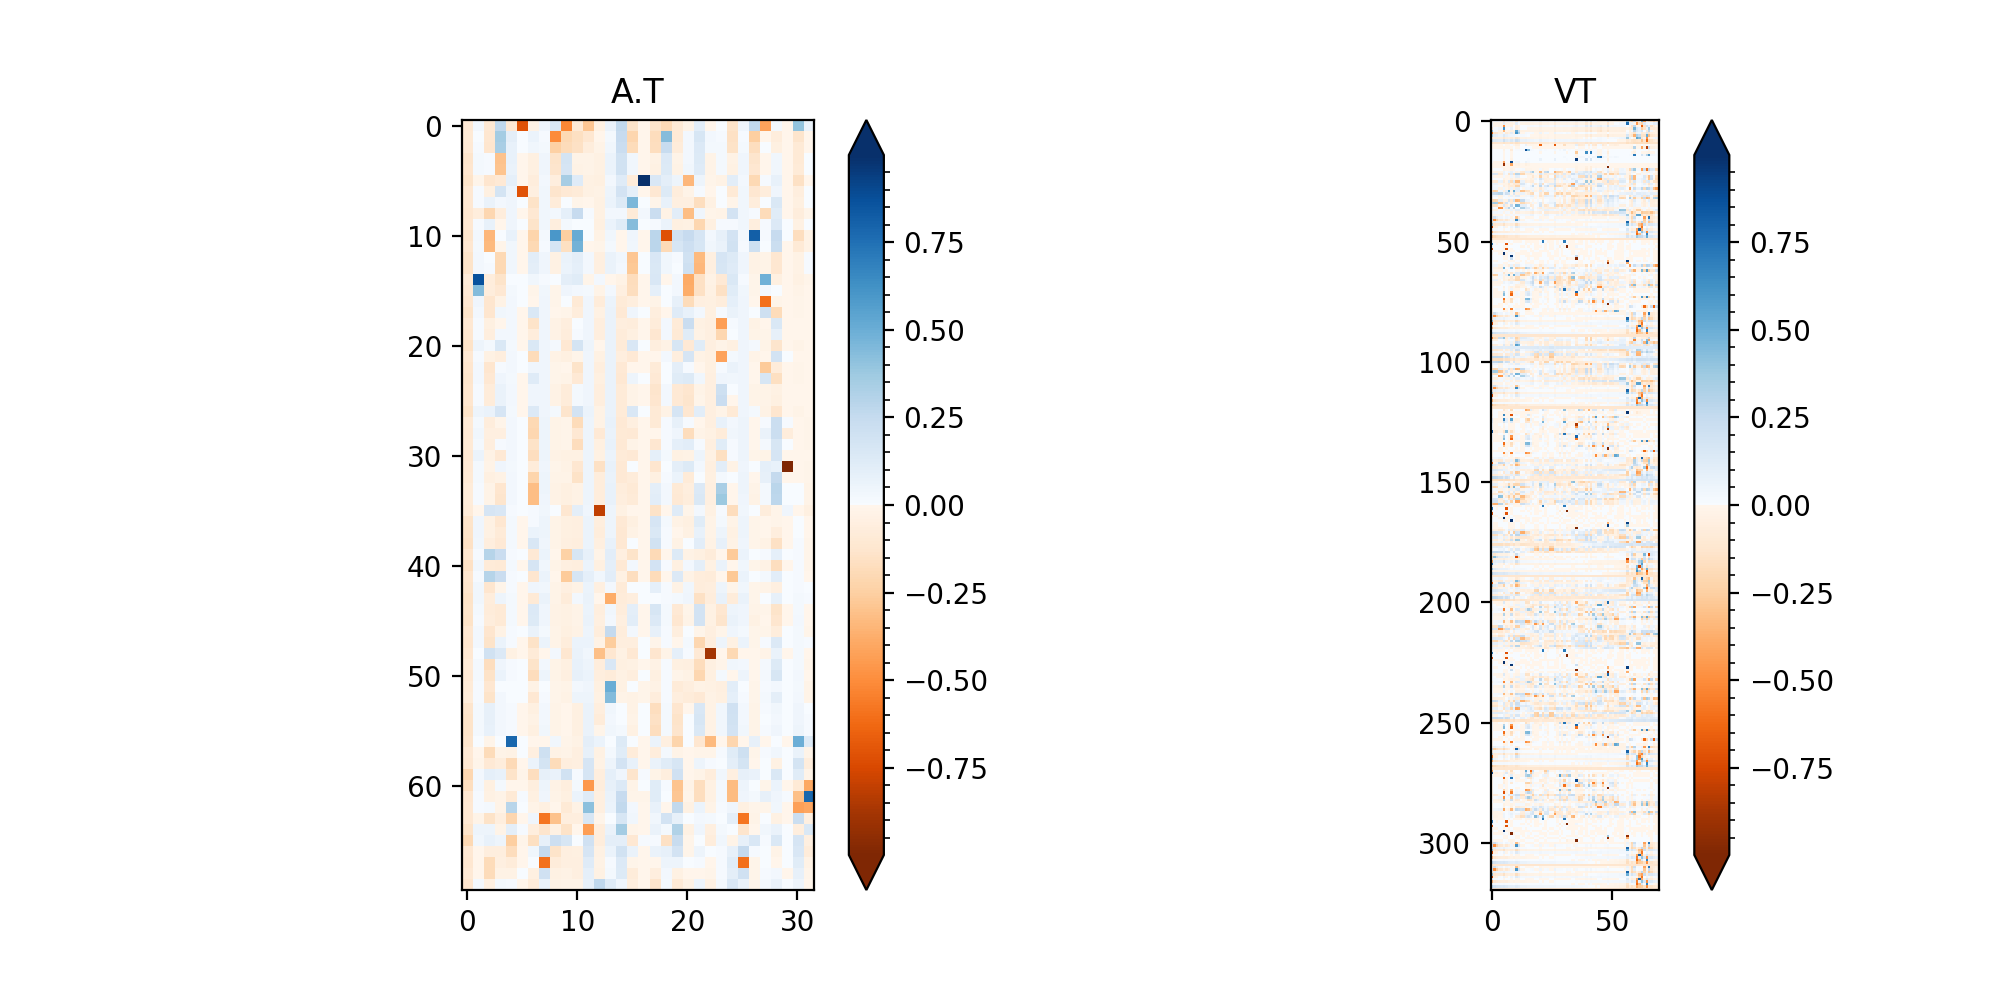

<IPython.core.display.Javascript object>


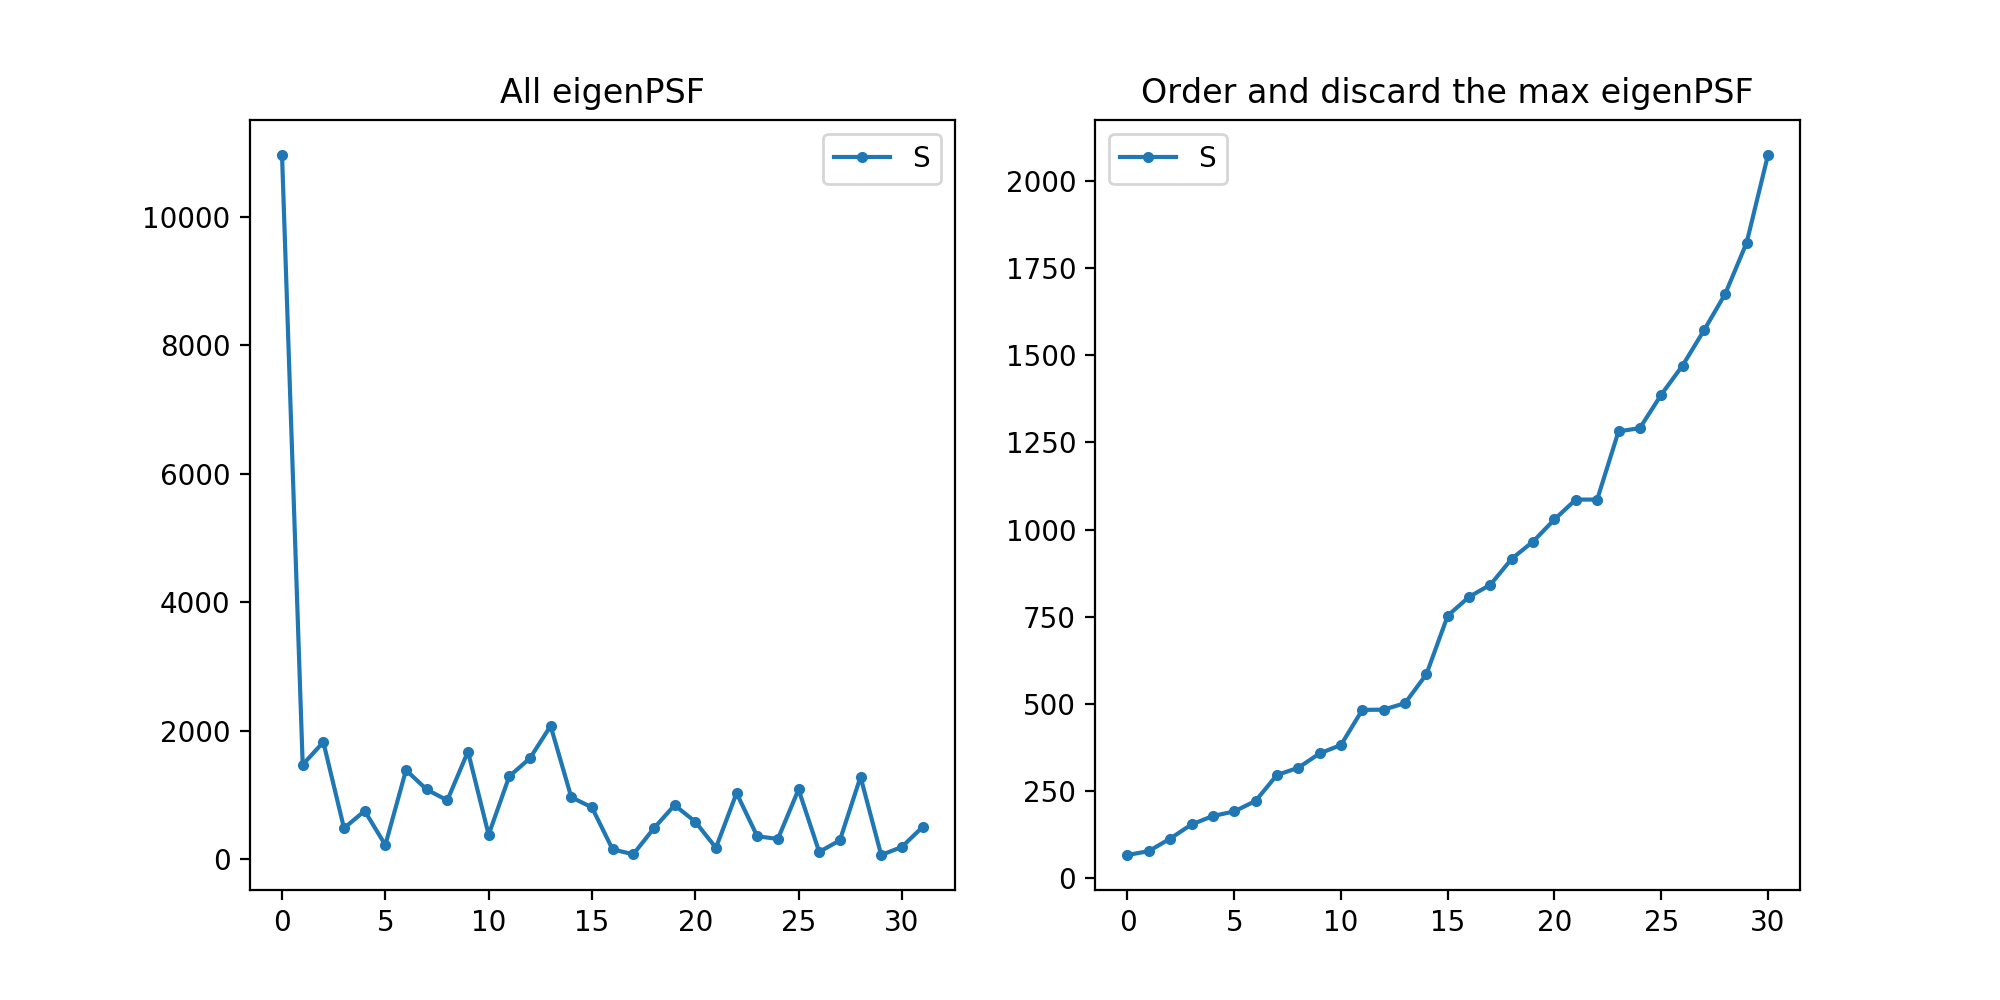

<IPython.core.display.Javascript object>


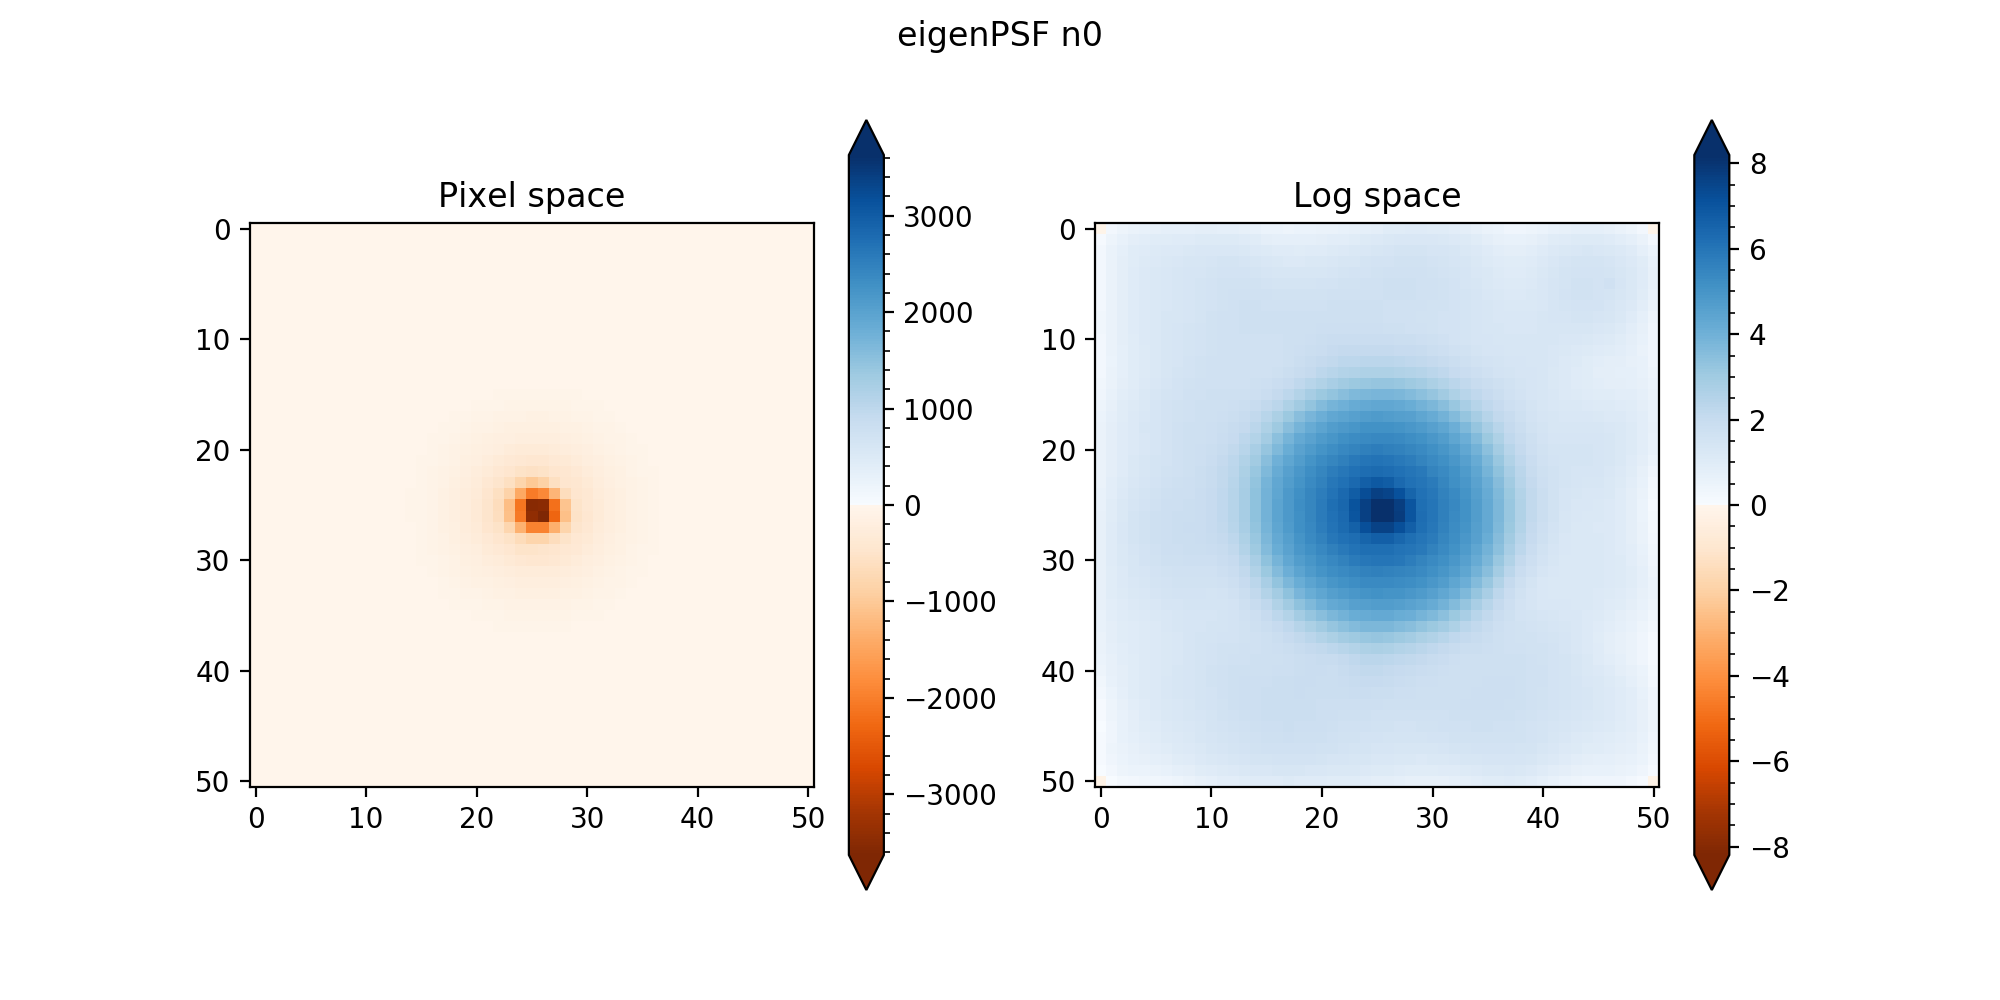

<IPython.core.display.Javascript object>


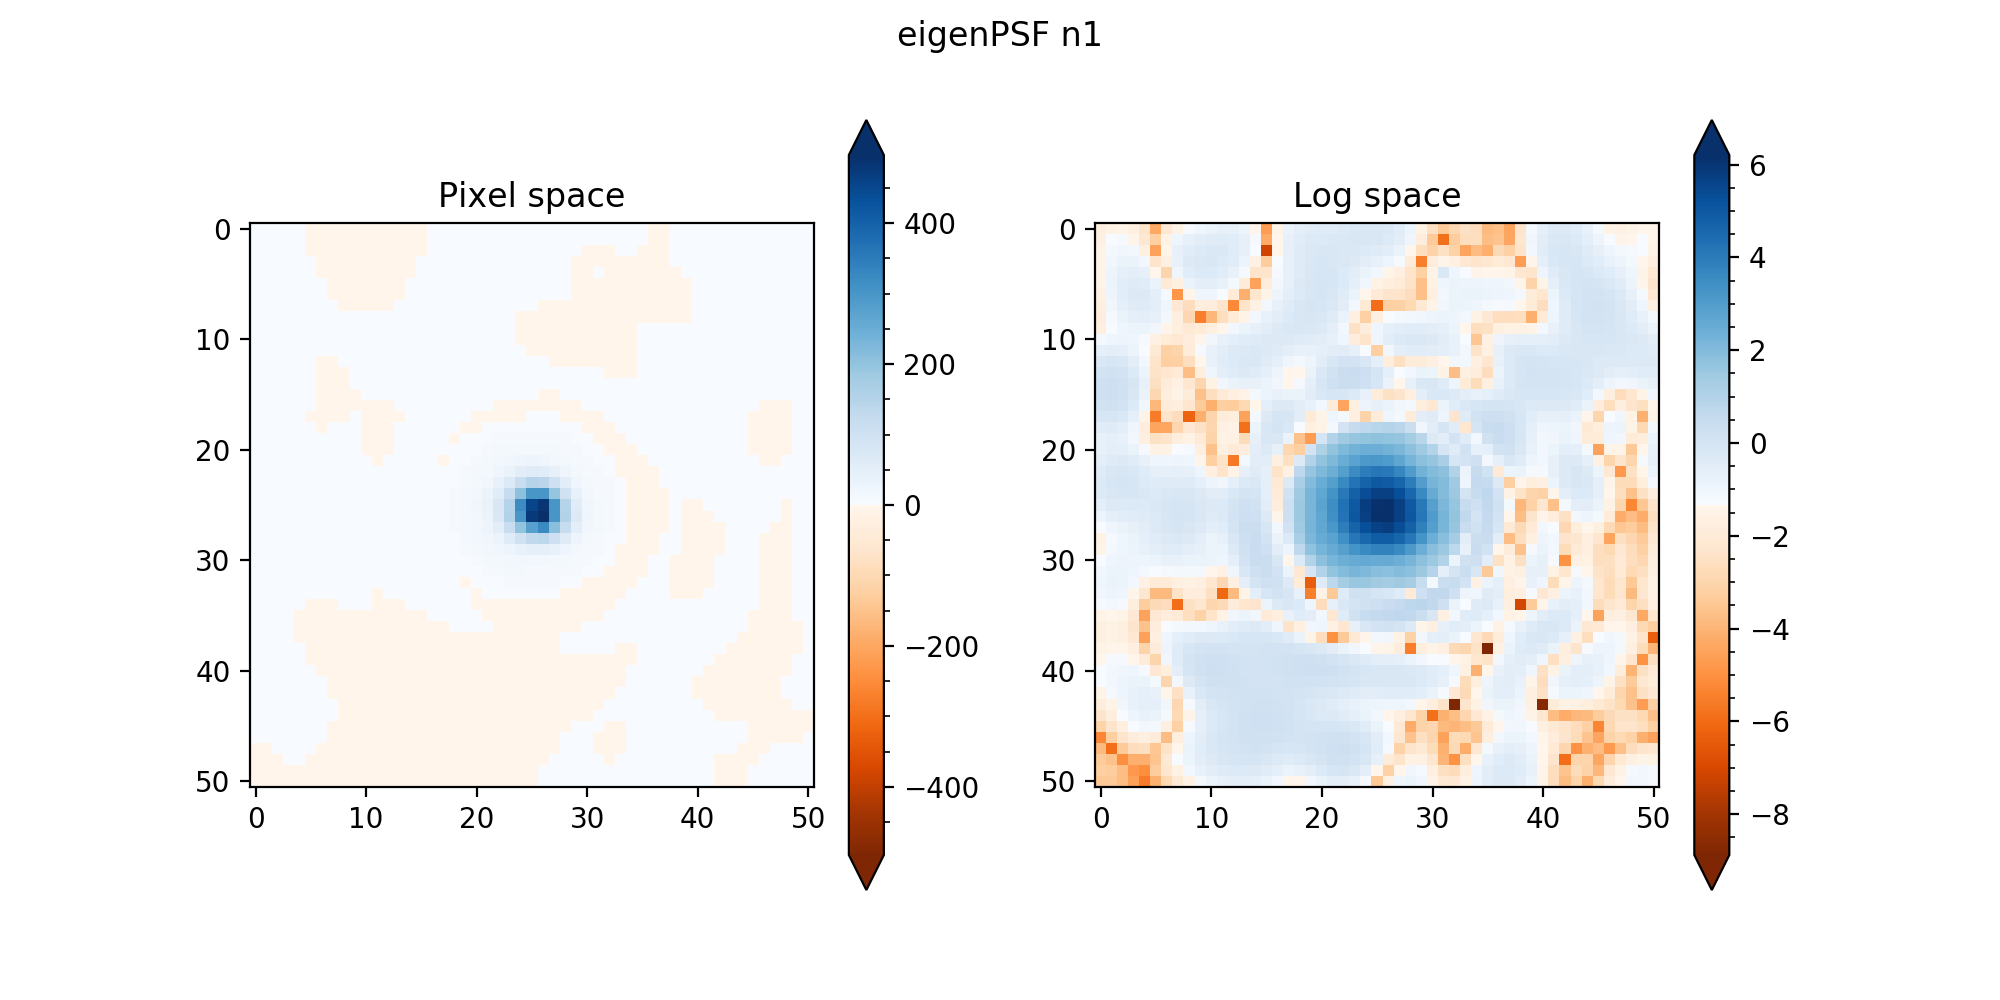

<IPython.core.display.Javascript object>


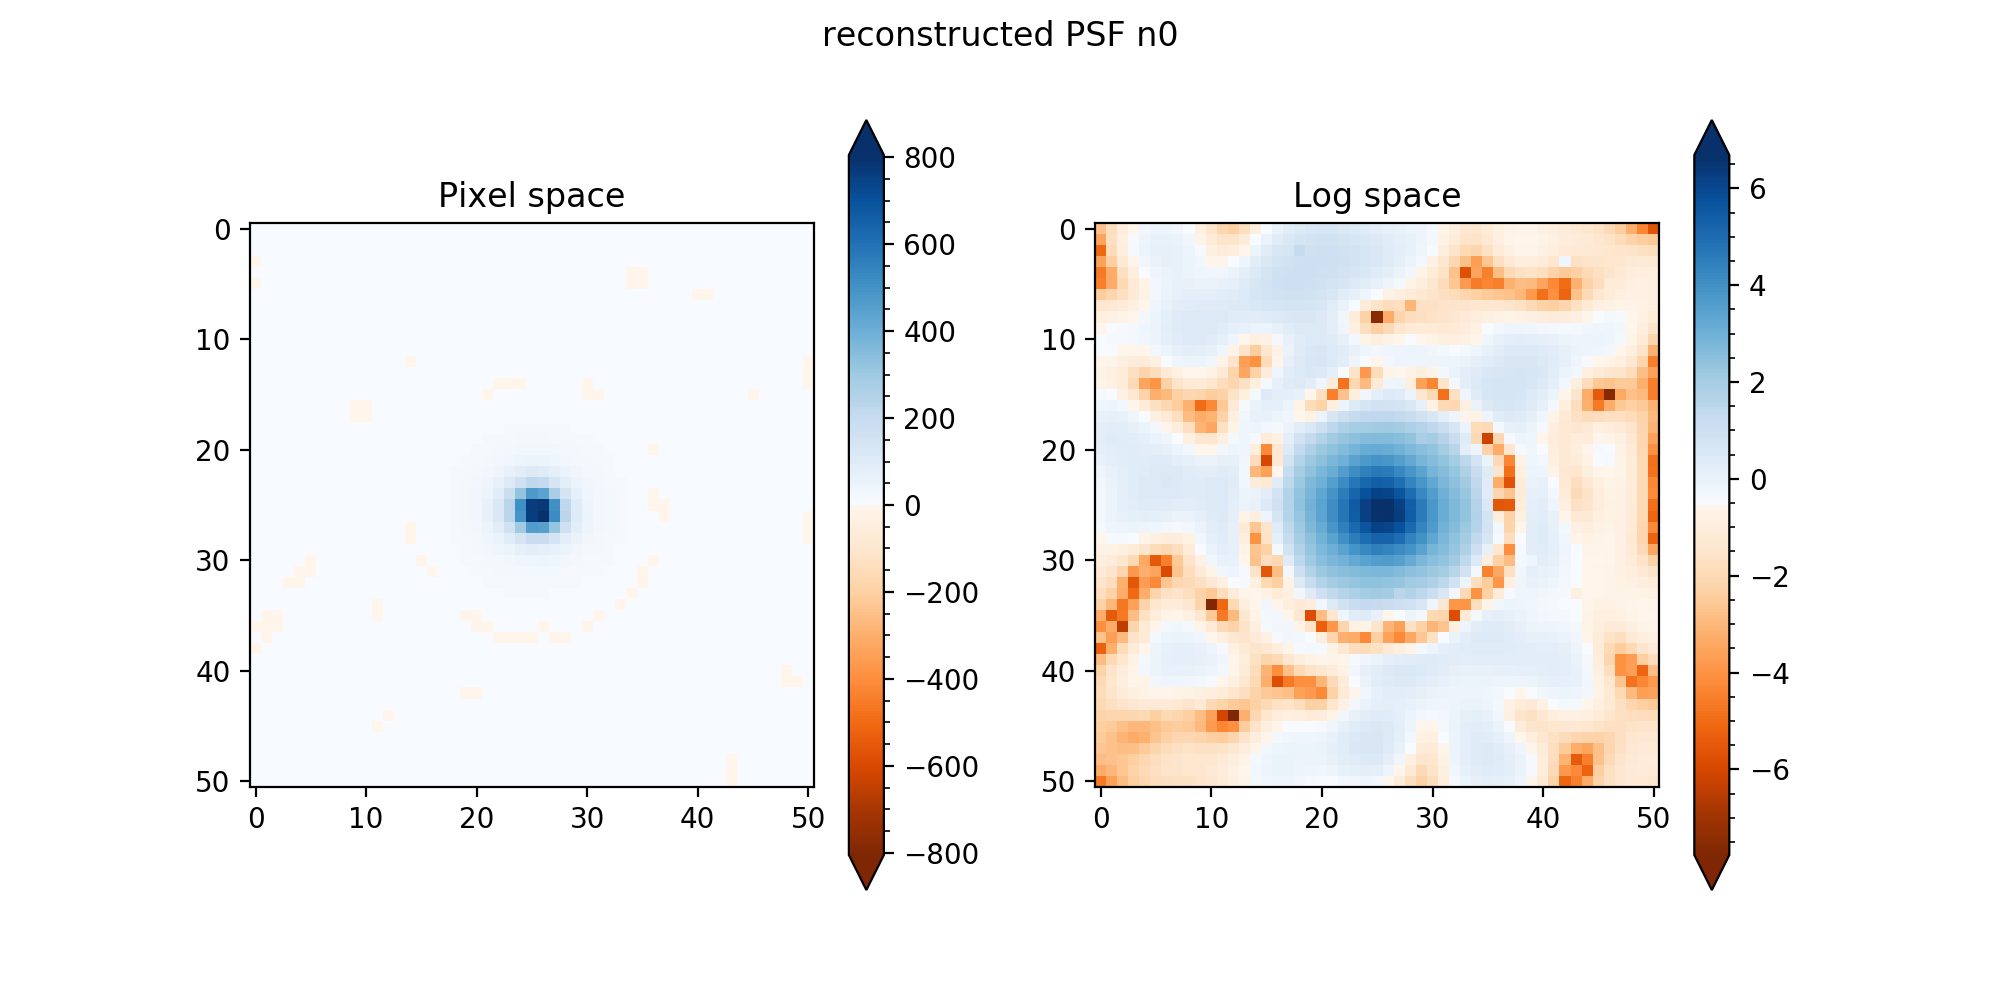

In [256]:
# Plot the A and VT matrices
figs, axs = plt.subplots(1,2,figsize=(10,5))

im_0 = axs[0].imshow(data_A.T, cmap=newcmp, vmin=-vmax1_A, vmax=vmax1_A)
axs[0].set_title('A.T')
#plt.colorbar(im_0, ax = axs[0])
cbar = fig.colorbar(im_0, ax=axs[0], extend='both')
cbar.minorticks_on()

im_1 = axs[1].imshow(data_VT, cmap=newcmp, vmin=-vmax1_VT, vmax=vmax1_VT)
axs[1].set_title('VT')
#plt.colorbar(im_1, ax = axs[1])
cbar = fig.colorbar(im_1, ax=axs[1], extend='both')
cbar.minorticks_on()


# Plot the norm of S and H lines
# a_lines = np.array([np.sqrt(np.sum(data_A[k,:]**2)) for k in range(data_A.shape[0])])
s_imgs = np.array([np.sqrt(np.sum(data_S[:,:,k]**2)) for k in range(data_S.shape[2])])
data_H = data_S @ data_A
h_imgs = np.array([np.sqrt(np.sum(data_H[:,:,k]**2)) for k in range(data_H.shape[2])])

sort_idxs = np.argsort(s_imgs).astype(int)[:-1] # Do not include the max eigenPSF

figs2, axs2 = plt.subplots(1,2,figsize=(10,5))

axs2[0].plot(s_imgs, marker='o', markersize=3, label='S')
#axs2[0].plot(h_imgs, marker='o', markersize=3, label='H')
axs2[0].set_title('All eigenPSF')
axs2[0].legend()

axs2[1].plot(s_imgs[sort_idxs], marker='o', markersize=3, label='S')
#axs2[1].plot(h_imgs[sort_idxs], marker='o', markersize=3, label='H')
axs2[1].set_title('Order and discard the max eigenPSF')
axs2[1].legend()
plt.show()

# Plot two eigen PSF
PSF_n = 0
plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))
PSF_n = 1
plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))

# Plot one reconstructed PSF
recPSF_n = 0
plot_img(data_H[:,:,recPSF_n], title_str = 'reconstructed PSF n%d'%(recPSF_n))